In [1]:
# ! pip install neuralprophet[live]

In [2]:
import os
import sys
import torch 
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet

/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [4]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 1
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 30
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [5]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # # cal roll mean
    # regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    # regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    # regions_df[region] = (regions_df[region]-regions_df[region].min())/(regions_df[region].max()-regions_df[region].min())
    
    # # add week info
    # regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    # regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [6]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,1.000000,0.000000,0.291667,0.416667
2013-03-02,30.750000,42.083333,36.625000,66.666667,824.916667,29.750000,0.616667,1026.850000,-15.937500,0.0,1.479167,0.625000,0.208333,0.583333,0.375000
2013-03-03,76.916667,120.541667,61.291667,81.000000,1620.625000,19.125000,5.566667,1014.608333,-12.316667,0.0,1.658333,0.833333,0.083333,0.458333,0.375000
2013-03-04,22.708333,44.583333,23.015778,46.542748,595.019788,53.750000,9.962500,1017.650000,-11.683333,0.0,2.404167,0.500000,0.500000,0.208333,0.416667
2013-03-05,148.875000,183.791667,93.875000,132.833333,2357.958333,68.458333,6.291667,1010.900000,-7.525000,0.0,1.129167,0.833333,0.166667,0.708333,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,21.541667,32.625000,16.583333,58.875000,575.000000,50.791667,5.166667,1021.012500,-11.141667,0.0,1.595833,0.791667,0.083333,0.333333,0.625000
2017-02-25,11.208333,19.708333,6.750000,43.375000,420.833333,65.875000,7.245833,1018.812500,-10.754167,0.0,1.825000,0.750000,0.166667,0.083333,0.833333
2017-02-26,28.125000,40.708333,10.083333,65.375000,720.833333,48.625000,7.208333,1020.337500,-8.258333,0.0,1.566667,0.541667,0.416667,0.500000,0.416667


In [7]:
models = {}
metrics = {}
forecasts = {}

for feature in POLUTION_FEATURES:
    # build model
    models[feature] = NeuralProphet(seasonality_mode="multiplicative", epochs=10)
    # build dataset
    df = regions_df[Region.AOTIZHONGXIN][[feature]]
    df = df.reset_index()
    df.columns = ['ds','y']
    # build metrics
    metrics[feature] = models[feature].fit(df, freq="H")
    # build forcast
    forecasts[feature] = models[feature].predict(df)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


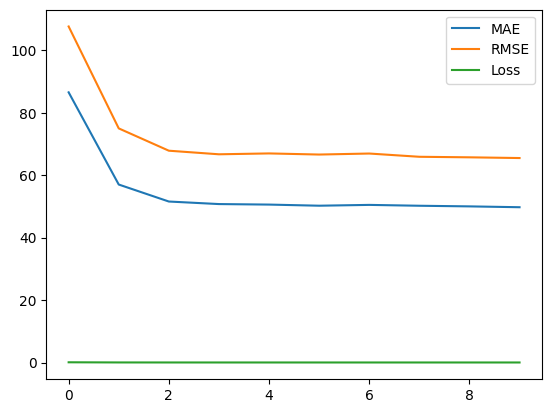

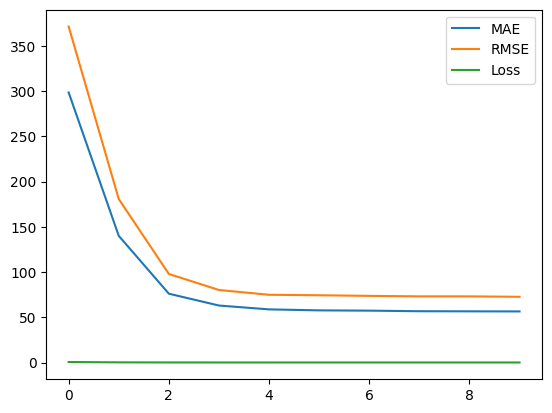

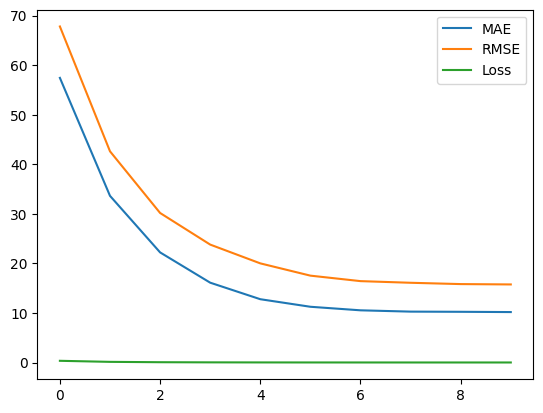

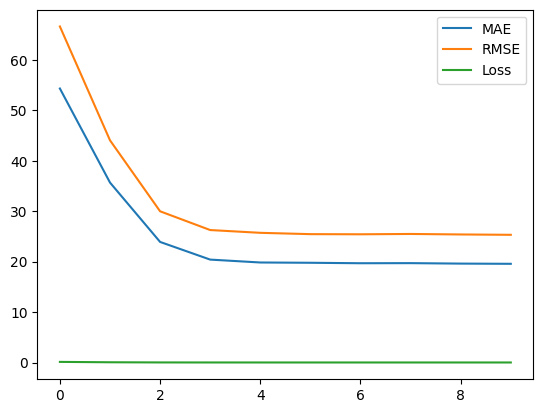

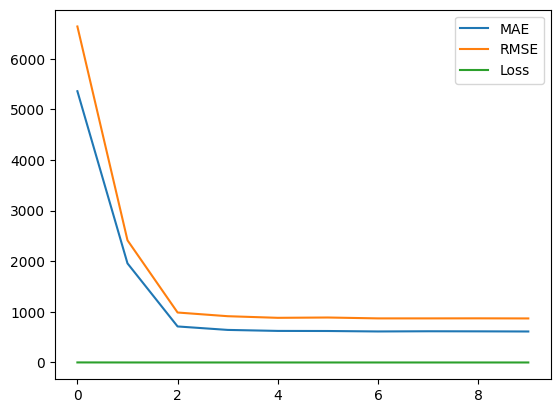

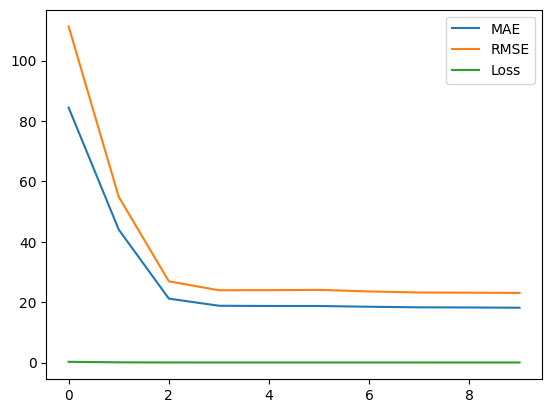

In [8]:
for feature in POLUTION_FEATURES:
    metrics[feature][['MAE','RMSE','Loss']].plot()

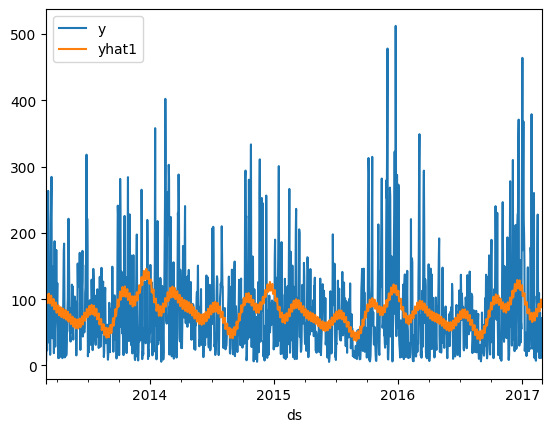

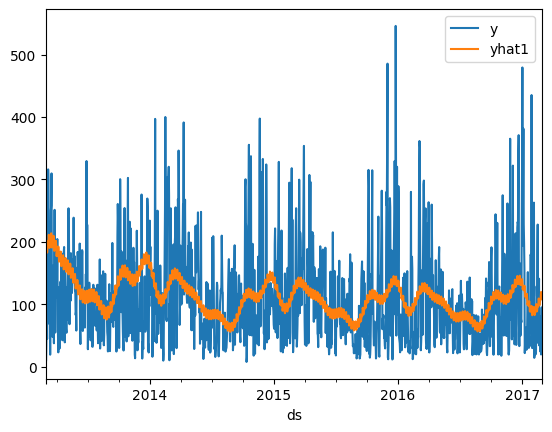

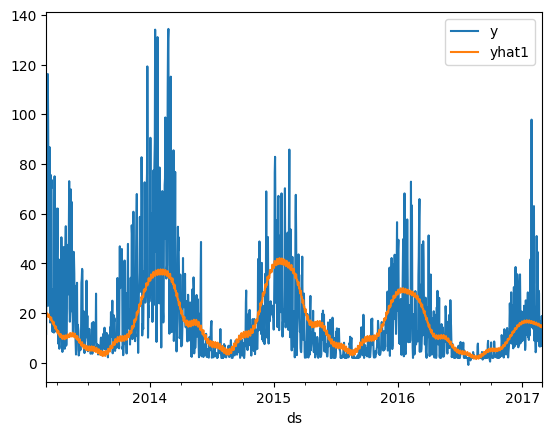

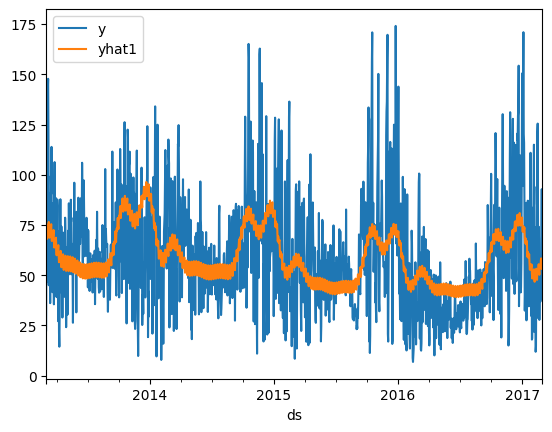

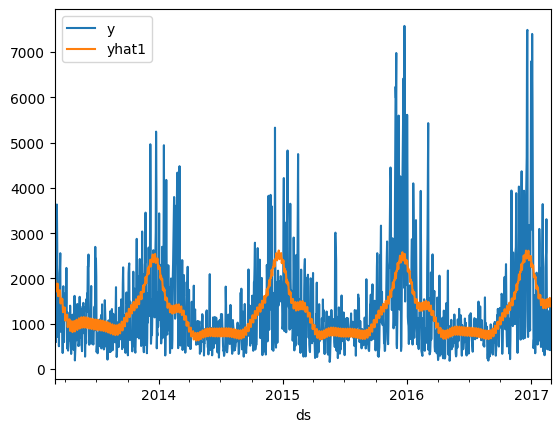

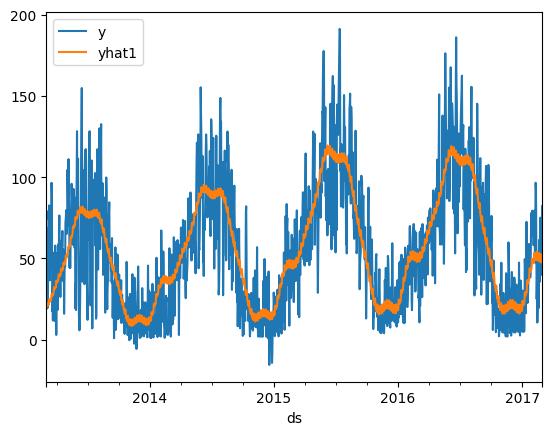

In [9]:
for feature in POLUTION_FEATURES:
    forecasts[feature].set_index('ds')[['y','yhat1']].plot()

In [10]:

for feature in POLUTION_FEATURES:
    # set index as date time
    forecasts[feature] = forecasts[feature].set_index('ds')
    # rename columns 
    forecasts[feature].columns = [f"{column}_{feature}" for column in forecasts[feature].columns]

combined_fetures_forcast_df = pd.concat(list(forecasts.values()), axis=1)

In [11]:
combined_fetures_forcast_df

,y_PM2.5,yhat1_PM2.5,trend_PM2.5,season_yearly_PM2.5,season_weekly_PM2.5,y_PM10,yhat1_PM10,trend_PM10,season_yearly_PM10,season_weekly_PM10,...,y_CO,yhat1_CO,trend_CO,season_yearly_CO,season_weekly_CO,y_O3,yhat1_O3,trend_O3,season_yearly_O3,season_weekly_O3
ds,,,,,,,,,,,,,,,,,,,,,
2013-03-01,7.125000,102.007027,85.135429,14.291467,2.580133,10.750000,187.547546,159.913452,27.086288,0.547796,...,429.166667,1890.378662,1588.105347,274.017273,28.256020,63.875000,19.715811,28.907724,-8.091370,-1.100543
2013-03-02,30.750000,107.632164,85.115662,14.742306,7.774200,42.083333,202.031021,159.750946,29.093601,13.186466,...,824.916667,1966.618530,1587.268433,269.471161,109.878899,29.750000,20.244860,29.039152,-8.069009,-0.725283
2013-03-03,76.916667,99.559357,85.095894,15.109299,-0.645834,120.541667,195.711182,159.588425,30.991095,5.131659,...,1620.625000,1860.344971,1586.431641,263.510345,10.403159,19.125000,22.994154,29.170580,-8.023529,1.847100
2013-03-04,22.708333,94.079414,85.076118,15.391668,-6.388377,44.583333,182.796631,159.425919,32.770412,-9.399689,...,595.019788,1707.090210,1585.594604,256.095245,-134.599670,53.750000,22.598223,29.302011,-7.953794,1.250009
2013-03-05,148.875000,98.504913,85.056351,15.589343,-2.140781,183.791667,191.279343,159.263397,34.424225,-2.408271,...,2357.958333,1835.853394,1584.757690,247.199677,3.895978,68.458333,21.280863,29.433439,-7.858901,-0.293673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,21.541667,93.845467,81.100082,10.295650,2.449727,32.625000,110.578194,100.671326,9.572344,0.334522,...,575.000000,1507.192993,1269.889282,215.336548,21.967239,50.791667,47.529175,63.853561,-14.356725,-1.967663
2017-02-25,11.208333,99.586838,81.112259,11.090297,7.384285,19.708333,119.777016,100.673828,11.041807,8.061377,...,420.833333,1572.173096,1270.037842,216.650101,85.485237,65.875000,48.121300,63.852211,-14.438036,-1.292882
2017-02-26,28.125000,92.330688,81.124420,11.819958,-0.613692,40.708333,116.298134,100.676338,12.481180,3.140616,...,720.833333,1495.452271,1270.186401,217.166351,8.099432,48.625000,52.640770,63.850853,-14.492949,3.282865


In [12]:
from torch import Tensor
from numpy import concatenate, clip
from torch.utils.data import Dataset
from numpy.lib.stride_tricks import sliding_window_view

class FeatureForcastingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, feature:str, model_features:list=POLUTION_FEATURES, split_date:str='2016-03-01 00:00:00', is_train:bool=True):  

        # split to train and test 
        df = df[df.index < split_date] if is_train else df[df.index >= split_date] 
        
        # normalize
        self.mean = df.mean()
        self.std = df.std()
        df = ( df - self.mean ) / self.std
        
        # build features 
        feature_list = [f"{col}_{feature}" for feature in model_features for col in ['trend', 'season_yearly', 'season_weekly']]
        features = df[feature_list].to_numpy()
  
        # build targets
        target = df[[f'y_{feature}']].to_numpy()

        # build datset
        self.features = Tensor(features)
        self.targets = Tensor(target)

        # discard variables
        del df

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
datset = FeatureForcastingDataset(combined_fetures_forcast_df,MODEL_INPUT_FEATURES[0],is_train=True)
datset[1]

(tensor([ 0.3358,  0.7916,  1.9681,  2.6087,  1.2222,  2.7085, -2.9845,  0.8730,
          1.2017,  1.7857,  0.0973,  1.8559,  2.6088,  0.5347,  2.0319, -2.5363,
         -0.2629, -0.4569]),
 tensor([-0.7710]))

In [13]:
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from sklearn.metrics import r2_score
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError

class FeatureForecastingModel(pl.LightningModule):
    def __init__(self, model_features:list=POLUTION_FEATURES, hidden_layer_size:int=2048, hidden_layers:int=3):
        super(FeatureForecastingModel, self).__init__()
        
        # init model features
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size

        layer_list = []

        # building input layer
        layer_list.append(nn.Linear(in_features=(len(model_features)*3), out_features=self.hidden_layer_size))
        layer_list.append(nn.LeakyReLU(0.1))
        # building hidden layers
        for h_layer in range(self.hidden_layers):
            layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=self.hidden_layer_size))
            layer_list.append(nn.LeakyReLU(0.1))
        # building ouput layer
        layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=1))

        # build model
        self.layers = nn.Sequential(*layer_list)
        
        # metics
        self.r2_score = R2Score()
        self.mae = MeanAbsoluteError()
        self.rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # Flatten the input images
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.r2_score(y_hat, y)
        self.log('r2_score', self.r2_score, on_epoch=True)
        self.mae(y_hat, y)
        self.log('mae', self.mae, on_epoch=True)
        self.rmse(y_hat, y)
        self.log('rmse', self.rmse, on_epoch=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)

In [14]:
from torch.utils.data import DataLoader 
import torch 
torch.set_float32_matmul_precision('medium')

import mlflow

# Auto log all MLflow entities
mlflow.pytorch.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("NP-MM")

# Train the models
with mlflow.start_run() as parent_run:
    parent_run_id = parent_run.info.run_id

    for feature in POLUTION_FEATURES:
         # Build Bataset
        train_dataset = FeatureForcastingDataset(combined_fetures_forcast_df,feature,is_train=True)
        val_dataset = FeatureForcastingDataset(combined_fetures_forcast_df,feature,is_train=False)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

        # build model
        models[feature] = FeatureForecastingModel(hidden_layer_size=2048, hidden_layers=3)

        # Create PyTorch Lightning trainer
        trainer = pl.Trainer(
            max_epochs=9,
            accelerator="gpu", 
            logger=False,
            enable_progress_bar=True,
            enable_checkpointing=False,
            devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
        )
        
        # log model into mlflow
        with mlflow.start_run(nested=True) as nested_run:
            nested_run_id = nested_run.info.run_id

            mlflow.log_param("feature", feature)
            # Train the model
            trainer.fit(models[feature], train_dataloaders=train_loader, val_dataloaders=val_loader)
            trainer.validate(models[feature], val_loader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:06:35 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/06/18 23:06:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │     0.708206832408905     │
│         r2_score          │   0.011188983917236328    │
│           rmse            │    0.9930266737937927     │
│         val_loss          │    0.9861019849777222     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:06:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.7262626886367798     │
│         r2_score          │    0.01111513376235962    │
│           rmse            │     0.993063747882843     │
│         val_loss          │    0.9861755967140198     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:07:01 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │     0.689408004283905     │
│         r2_score          │    0.03851735591888428    │
│           rmse            │    0.9792080521583557     │
│         val_loss          │    0.9588485360145569     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:07:14 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.7555699348449707     │
│         r2_score          │   0.027711451053619385    │
│           rmse            │    0.9846952557563782     │
│         val_loss          │    0.9696246981620789     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:07:28 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.6430081129074097     │
│         r2_score          │    0.04666244983673096    │
│           rmse            │    0.9750516414642334     │
│         val_loss          │    0.9507256746292114     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
2023/06/18 23:07:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.7710781097412109     │
│         r2_score          │    0.1006348729133606     │
│           rmse            │    0.9470486044883728     │
│         val_loss          │    0.8969011902809143     │
└───────────────────────────┴───────────────────────────┘